In [1]:
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import hist
import hist.dask as hda
import dask
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import vector

NanoAODSchema.warn_missing_crossrefs = False

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
import os
os.listdir('.')

['.ipynb_checkpoints',
 'samples.json',
 'fully_leptonic_test.ipynb',
 '.git',
 'README.md',
 'resonancesTest.ipynb',
 'semileptonic_test.ipynb',
 'leading_W_jet_pt.h5',
 'semileptonic_notebooks.tar.gz']

In [61]:
# Datasets:
#/BulkGravToWW_narrow_M-*_13TeV-madgraph/*NanoAODv7*/NANOAODSIM
#/RadionToWW_narrow_M-*_13TeV-madgraph/*NanoAODv7*/NANOAODSIM


# When having a large number of files it is useful to put the list on a separate file.
# import json

# with open("semileptonic_notebooks/samples.json", 'r') as sample_file:
#     fileset = json.load(sample_file)

# for sample in fileset:
#     print(sample)

# For now we are only testing on a limited number of files so they are just listed here
fileset = {
    'BulkGravToWW': {
        'files': {
            'root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv7/BulkGravToWW_narrow_M-1000_13TeV-madgraph/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/100000/D4404DCB-FBF8-C640-87B0-2DA1D5139083.root': "Events",
        },
        'metadata': {
            'is_mc': 'Events',
        },
    },
    'RadionToWW': {
        'files': {
            'root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv7/RadionToWW_narrow_M-1000_13TeV-madgraph/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/120000/B53216D7-B5CA-A347-A49A-5B055C71FB93.root': "Events",
          },
        'metadata': {
            'is_mc': 'Events',
        },
    }
}

In [68]:
# This step takes some time because it is loading the events
test_dataset = 'RadionToWW'
events = NanoEventsFactory.from_root(
    fileset[test_dataset]['files'],
    entry_stop = 10000,
    metadata = fileset[test_dataset]['metadata'],
    schemaclass = NanoAODSchema,
    delayed=False,
).events()

In [69]:
def get_w_decay_quark_pairs_gen(events):
    """
    Extraction of pairs of quarks coming from a W boson at generator level
    Gave a 'vector.Momentum4D'.
    """
    if events is None or len(events) == 0:
        return []
        
    pdgId = events.GenPart.pdgId
    mothers = events.GenPart.genPartIdxMother
    
    all_quark_pairs_vectors = []

    print(f"[INFO] Processing events to find W -> qq'.")
    num_w_decay_to_quarks = 0
    for i in range(len(events)): 
        event_pdgId = pdgId[i]
        event_mothers = mothers[i]
        
        # Label of the W boson in the actual event
        # abs(pdgId) == 24 for W+ and W-
        w_indices_in_event = ak.local_index(event_pdgId)[abs(event_pdgId) == 24]

        for w_idx in w_indices_in_event:
            # Indexes for the quarks doughters coming from to the W (abs(pdgId) between 1 and 6)
            daughter_indices = ak.local_index(event_pdgId)[
                (event_mothers == w_idx) & (abs(event_pdgId) >= 1) & (abs(event_pdgId) <= 6)
            ]
            
            if len(daughter_indices) == 2:
                num_w_decay_to_quarks += 1
                q1_data = {
                    "pt": events.GenPart.pt[i][daughter_indices[0]],
                    "eta": events.GenPart.eta[i][daughter_indices[0]],
                    "phi": events.GenPart.phi[i][daughter_indices[0]],
                    "mass": events.GenPart.mass[i][daughter_indices[0]],
                }
                q2_data = {
                    "pt": events.GenPart.pt[i][daughter_indices[1]],
                    "eta": events.GenPart.eta[i][daughter_indices[1]],
                    "phi": events.GenPart.phi[i][daughter_indices[1]],
                    "mass": events.GenPart.mass[i][daughter_indices[1]],
                }
                q1_vec = vector.obj(pt=q1_data["pt"], eta=q1_data["eta"], phi=q1_data["phi"], mass=q1_data["mass"])
                q2_vec = vector.obj(pt=q2_data["pt"], eta=q2_data["eta"], phi=q2_data["phi"], mass=q2_data["mass"])
                all_quark_pairs_vectors.append([q1_vec, q2_vec])
                
    print(f"[INFO] Found {len(all_quark_pairs_vectors)} pairs of quarks {num_w_decay_to_quarks} for W->qq'.")
    return all_quark_pairs_vectors


In [70]:
w_decay_quark_pairs_gen = get_w_decay_quark_pairs_gen(events)

[INFO] Processing events to find W -> qq'.
[INFO] Found 13371 pairs of quarks 13371 for W->qq'.


In [71]:
def calculate_cos_theta_star_gen(quark_pairs_vectors):
    """
    Computation cos(theta*) for the list of pair of quarks.
    theta* is the angle betweeen the quark direction (in the W rest frame) and the dirección of W (in the lab frame).
    """
    cos_theta_stars = []

    if not quark_pairs_vectors:
        print(f"[WARN] Quark pairs not loaded for computation of cos(theta*).")
        return np.array([])
    print(len(quark_pairs_vectors))
    for q_pair in quark_pairs_vectors:
        q1 = q_pair[0] 
        q2 = q_pair[1]
        w_lab = q1 + q2 
        if w_lab.mass < 1e-3 or w_lab.E <= 1e-6:
            print("1")
            continue 

        beta3 = w_lab.to_beta3()
        q1_in_w_rest = q1.boost_beta3(-beta3)
        
        # Axis z' in the helicity frame
        w_direction_lab_3vec = w_lab.to_beta3() 

        if w_direction_lab_3vec.mag < 1e-6:
            continue 
        
        q1_direction_w_rest_3vec = q1_in_w_rest.to_beta3()
        
        if q1_direction_w_rest_3vec.mag < 1e-6: 
            continue

        cos_theta = q1_direction_w_rest_3vec.unit().dot(w_direction_lab_3vec.unit())
        cos_theta_stars.append(cos_theta)
        
    print(f"[INFO] Computed {len(cos_theta_stars)} values of cos(theta*).")
    return np.array(cos_theta_stars)

In [72]:
cos_theta_star_gen = calculate_cos_theta_star_gen(w_decay_quark_pairs_gen)
print(cos_theta_star_gen)


13371
[INFO] Computed 13371 values of cos(theta*).
[-0.30413845  0.39207097 -0.66858869 ... -0.24748987 -0.07706242
 -0.64414343]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4b6da54c80>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

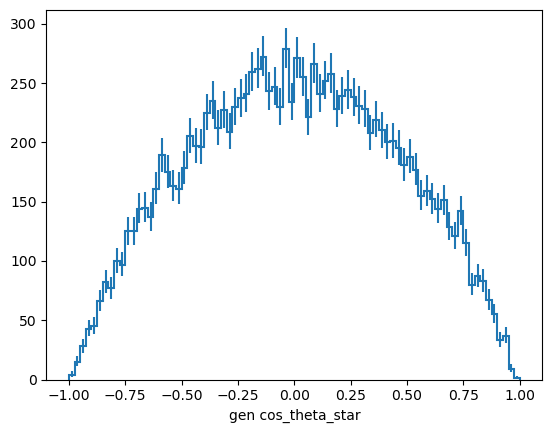

In [73]:
gen_cos_theta_star_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="BG", categories=[], growth=True),
                            hist.axis.Regular(name='gen_AK8_cos_theta_star', label='gen cos_theta_star', bins=80, start=-1, stop=1))
gen_cos_theta_star_hist.fill(dataset=test_dataset, gen_AK8_cos_theta_star=cos_theta_star_gen)
gen_cos_theta_star_hist.plot1d()

In [5]:
events.fields

['Electron',
 'Generator',
 'SoftActivityJet',
 'HTXS',
 'ChsMET',
 'HLTriggerFinalPath',
 'L1PreFiringWeight',
 'SoftActivityJetNjets2',
 'SoftActivityJetNjets10',
 'GenIsolatedPhoton',
 'Tau',
 'run',
 'LHEScaleWeight',
 'GenJet',
 'PuppiMET',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'LHEReweightingWeight',
 'FatJet',
 'SoftActivityJetNjets5',
 'genWeight',
 'SoftActivityJetHT2',
 'OtherPV',
 'fixedGridRhoFastjetCentralCalo',
 'LHEPdfWeight',
 'Flag',
 'luminosityBlock',
 'IsoTrack',
 'LHE',
 'Jet',
 'PSWeight',
 'TrigObj',
 'fixedGridRhoFastjetCentral',
 'GenMET',
 'FsrPhoton',
 'GenDressedLepton',
 'RawMET',
 'btagWeight',
 'Photon',
 'HLTriggerFirstPath',
 'event',
 'PV',
 'TkMET',
 'RawPuppiMET',
 'MET',
 'Pileup',
 'GenVisTau',
 'LHEWeight',
 'fixedGridRhoFastjetCentralNeutral',
 'LHEPart',
 'CorrT1METJet',
 'SubJet',
 'GenJetAK8',
 'GenPart',
 'SoftActivityJetHT',
 'genTtbarId',
 'SV',
 'SoftActivityJetHT5',
 'Muon',
 'HLT',
 'CaloMET',
 'SubGenJetAK8',
 'L1',
 'fixedGridRh

In [6]:
# Samples from 2018...

muons = events.Muon
electrons = events.Electron

# Exactly one tightly identified electron or muon
electron_pt_threshold = 35
muon_pt_threshold = 30
pt_miss_threshold = 30

# Muon TightHWW selection
muons_tightHWW = muons[
    (muons.pt > 10) &
    (np.abs(muons.eta) < 2.4) &
    (muons.tightId) &
    (
        ((muons.pt < 20) & (np.abs(muons.dxy) < 0.01)) |
        ((muons.pt >= 20) & (np.abs(muons.dxy) < 0.02))
    ) &
    (np.abs(muons.dz) < 0.1) &
    # particle flow isolated: tight or greater
    (muons.pfIsoId >= 4)
]

In [ ]:
loose_muons = muons[muons.looseId]
loose_muon_count = ak.num(loose_muons[loose_muons.pt > 10])

loose_electrons = electrons[(electrons.cutBased >= 2)]
loose_electron_count = ak.num(loose_electrons[loose_electrons.pt > 10])

# Mask for vetoing extra loose leptons
loose_lepton_veto_mask = (loose_muon_count + loose_electron_count) == 1

In [19]:

clean_fatJets = events.FatJet[(events.FatJet.pt > 200) & (np.abs(events.FatJet.eta) < 2.4)]



In [20]:
#Jets cuts
clean_Jets = events.Jet[(events.Jet.pt > 30) & (np.abs(events.Jet.eta) < 4.7)]

#Removing AK4(Jet) jets overlapping with AK8(FatJets) jets
# Get all combinations of jets and fatjets in every event
jets_fatjets = ak.cartesian({"x": clean_Jets, "y": clean_fatJets})
# Check that jets satisfy the isolation
jets_iso_f = ((jets_fatjets["x"].eta-jets_fatjets["y"].eta)**2+(jets_fatjets["x"].phi-jets_fatjets["y"].phi)**2>0.8**2)
# Mask the jets_fatjets with the jets_iso_f to get jets isolated from fatjets
jets_fatjets = jets_fatjets[jets_iso_f]
# Separate pairs into jets and fatjets, redefining the jets (but not the fatjets)
jets, fj = ak.unzip(jets_fatjets)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2f850c5fd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

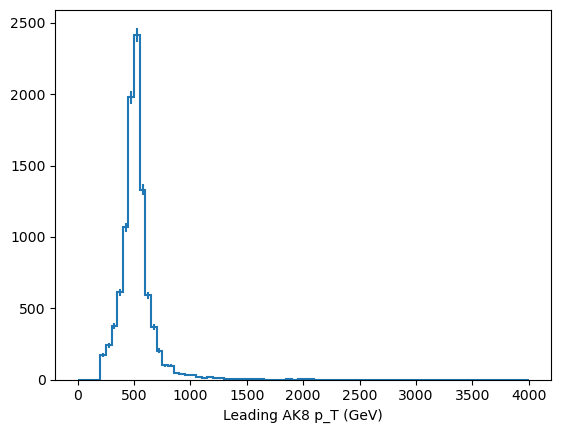

In [21]:
AK8jets_candidates_mask = ak.num(clean_fatJets) >= 1

Wjets_candidates = clean_fatJets[AK8jets_candidates_mask]
leading_W_jet = Wjets_candidates[:, 0]
leading_W_jet_pt = leading_W_jet.pt

leading_W_pt_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="Dataset", categories=[], growth=True),
                            hist.axis.Regular(name='leading_AK8_pt', label='Leading AK8 p_T (GeV)', bins=80, start=0, stop=4000))
leading_W_pt_hist.fill(dataset=test_dataset, leading_AK8_pt=leading_W_jet_pt)
leading_W_pt_hist.plot1d()

In [ ]:
# basic h5 creation
import pandas as pd
# Convert awkward array to numpy array (flat)
leading_W_jet_pt_np = ak.to_numpy(leading_W_jet_pt)
leading_W_jet_eta_np = ak.to_numpy(leading_W_jet.eta)
# Optional — wrap in a DataFrame for easy labeling
df_leading_W_jet_pt = pd.DataFrame({'leading_W_jet_pt': leading_W_jet_pt_np, 'leading_W_jet_eta': leading_W_jet_eta_np})


In [49]:
df_leading_W_jet_pt.to_hdf('leading_W_jet_pt.h5', key='df', mode='w')


In [51]:
pd.read_hdf('leading_W_jet_pt.h5')


,leading_W_jet_pt,leading_W_jet_eta
0,366.250,0.178833
1,443.250,-0.152985
2,480.000,-1.210205
3,319.750,-1.611572
4,474.750,-0.145081
...,...,...
9194,240.625,-1.124023
9195,377.750,-0.402466
9196,344.000,-1.494141
9197,606.000,-0.218109


In [22]:
def get_w_decay_subjet_pairs(fatjets, subjets):
    """
    Return vector pairs from subjets of FatJets (W→qq′ candidates).
    Assumes SubJets are matched to FatJets already.
    """
    # if events is None or len(events) == 0:
    #     return []

    # fatjets = events.FatJet
    # subjets = events.SubJet

    # Filter fatjets with at least 2 subjets
    fatjet_has_2subjets = ak.num(subjets) >= 2
    fatjets = fatjets[fatjet_has_2subjets]
    subjets = subjets[fatjet_has_2subjets]

    # Take first two subjets for each fatjet
    sj1 = subjets[:, 0]
    sj2 = subjets[:, 1]

    # Build vector objects from the subjets
    q1_vec = ak.zip({
        "pt": sj1.pt,
        "eta": sj1.eta,
        "phi": sj1.phi,
        "mass": sj1.mass
    }, with_name="Momentum4D")
    q2_vec = ak.zip({
        "pt": sj2.pt,
        "eta": sj2.eta,
        "phi": sj2.phi,
        "mass": sj2.mass
    }, with_name="Momentum4D")

    # Combine them into pairs
    quark_pairs = ak.zip({
        "q1": q1_vec,
        "q2": q2_vec
    }, with_name="Momentum4D")
    print("number of subjets 1 ",len(sj1), " and 2 ",len(sj2))
    print(f"[INFO] Found {len(quark_pairs)} subjet pairs (possible W→qq′).")
    return quark_pairs

In [9]:
# Let's say we want the boost that brings the first two FatJets into the CM frame.
# Step 1: Convert to Lorentz vectors
fatjet_p4 = ak.zip({
    "pt": Wjets_candidates.pt,
    "eta": Wjets_candidates.eta,
    "phi": Wjets_candidates.phi,
    "mass": Wjets_candidates.mass,
}, with_name="Momentum4D")



In [23]:
# Select SubJets based on indices stored in the selected FatJets
subjet_idx1 = Wjets_candidates.subJetIdx1
subjet_idx2 = Wjets_candidates.subJetIdx2

# Create a mask to select valid indices (some entries might be -1)
valid = (subjet_idx1 >= 0) & (subjet_idx2 >= 0)

# Apply mask to Wjets_candidates
Wjets_with_subjets = Wjets_candidates[valid]
idx1 = subjet_idx1[valid]
idx2 = subjet_idx2[valid]

subjet_idx1 = subjet_idx1[valid]
subjet_idx2 = subjet_idx2[valid]

subjet_idx1 = Wjets_candidates.subJetIdx1
subjet_idx2 = Wjets_candidates.subJetIdx2

# Only keep jets where both indices are valid
valid_mask = (subjet_idx1 >= 0) & (subjet_idx2 >= 0)

# Apply mask to subjet indices
subjet_idx1_valid = subjet_idx1[valid_mask]
subjet_idx2_valid = subjet_idx2[valid_mask]

flat_idx1 = ak.flatten(subjet_idx1_valid)
flat_idx2 = ak.flatten(subjet_idx2_valid)

# Also flatten the matching FatJets
flat_fatjets = ak.flatten(Wjets_candidates[valid_mask])

# Flatten SubJets per event
all_subjets = ak.flatten(events.SubJet, axis=1)

# Get the matched subjets
subjet1 = all_subjets[flat_idx1]
subjet2 = all_subjets[flat_idx2]

In [11]:
# Mask fat jets passing cuts
fatjet_mask = (events.FatJet.pt > 200) & (np.abs(events.FatJet.eta) < 2.4)

# Select only those fat jets
selected_fatjets = events.FatJet[fatjet_mask]


# This works with BulkGraviton But not Radion 
clean_SubJets = events.SubJet[(events.FatJet.pt > 200) & (np.abs(events.FatJet.eta) < 2.4)]

AK8subjets_candidates_mask = ak.num(clean_SubJets) >= 1

Wjets_candidates_subjets= clean_SubJets[AK8subjets_candidates_mask]

In [24]:
w_decay_subjets_pairs = get_w_decay_subjet_pairs(Wjets_candidates, Wjets_candidates_subjets)

number of subjets 1  7743  and 2  7743
[INFO] Found 7743 subjet pairs (possible W→qq′).


In [38]:
def calculate_cos_theta_star(quark_pairs_vectors):
    """
    Computation cos(theta*) for the list of pair of quarks.
    theta* is the angle betweeen the quark direction (in the W rest frame) and the dirección of W (in the lab frame).
    """
    cos_theta_stars = []
    print(" In function pairs ", quark_pairs_vectors)
    # if not quark_pairs_vectors:
    #     print(f"[WARN] Quark pairs not loaded for computation of cos(theta*).")
    #     return np.array([])

    for q_pair in quark_pairs_vectors:
        q1 = q_pair.q1 
        q2 = q_pair.q2

        # print(type(q_pair.q1[0]))  # should show `Momentum4D` from vector
        # print(ak.type(q_pair.q1))  # show the full awkward type
        w_lab = (q1 + q2)
      
        if w_lab.mass < 1e-3 or w_lab.E <= 1e-6: 
            print("wrong mass or energy range")
            continue 
        #print("mass ", w_lab.mass)
        print(type(w_lab))
        neg_w_lab = -w_lab

        vec3 = neg_w_lab.to_Vector3D()
        energy = w_lab.E
        #print(ak.type(energy))
        #print(repr(energy))
        #print ("Energy ",energy, " other ", neg_w_lab.energy)
        
        # Avoid dividing by zero
        #safe_energy = energy if energy != 0 else 1.0  # Replace 0s with 1s temporarily

        rho = vec3.rho
        phi = vec3.phi
        eta = vec3.eta

        # Convert to Cartesian
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        z = rho * np.sinh(eta)

        # Construct vector object (Cartesian)
        p_vec = vector.obj(x=x, y=y, z=z)

        # energy must be a numpy or awkward array of floats (avoid zero division)
        safe_energy = np.where(energy != 0, energy, 1.0)

        # Compute beta vector components
        beta_x = x / safe_energy
        beta_y = y / safe_energy
        beta_z = z / safe_energy
        #print("beta_x ",beta_x)
        #print("beta_x/safe_energy ",beta_x/safe_energy)
        beta3 = vector.obj(x=beta_x, y=beta_y, z=beta_z)
        #print("beta3 ",beta3)
        #beta_vec = neg_w_lab.to_Vector3D() / neg_w_lab.energy
        #print("beta_vec ",beta_vec)
        #print("q1.boost ",q1.boost_beta3(beta3))
        q1_in_w_rest = q1.boost_beta3(beta3)
        # Boost q1 in the W rest frame W,ab.beta3
        # try:
        #     q1_in_w_rest = q1.boost_beta3(-w_lab.beta3) # original code
        #     print("w_lab ", w_lab)
        #     print("-w_lab ", -w_lab)
        #     beta_vec = -w_lab.to_Vector3D() / w_lab.energy
        #     print("beta_vec ",beta3)
        #     print("q1.boost ",q1.boost_beta3(beta3))
        #     q1_in_w_rest = q1.boost_beta3(beta3)
        # except Exception as e:
        #     print("no q1_in_w_rest")
        #     continue


        # Axis z' in the helicity frame
        w_direction_lab_3vec = w_lab.to_beta3() 
        w_direction_lab_3vec_mag = w_direction_lab_3vec.rho * np.cosh(w_direction_lab_3vec.eta)

        if w_direction_lab_3vec_mag < 1e-6: 
            print("too low w_direction_lab_3vec")
            continue 
        
        #print( "q1_in_w_rest ", q1_in_w_rest)
        q1_in_w_rest_vec = vector.obj(
            pt=q1_in_w_rest["x"],
            eta=q1_in_w_rest["y"],
            phi=q1_in_w_rest["z"],
            mass=q1_in_w_rest["tau"]
        )

        # Now it's a proper 4D vector and we can call:
        #q1_in_w_rest_3vec = q1_in_w_rest_vec.to_beta3()
        q1_direction_w_rest_3vec = q1_in_w_rest_vec.to_beta3()
        #q1_direction_w_rest_3vec = q1_in_w_rest_3vec.to_beta3() 
        
        if q1_direction_w_rest_3vec.mag < 1e-6: 
            print("too low q1_direction_w_rest_3vec")
            continue

        #print(q1_direction_w_rest_3vec.unit())
        cos_theta = q1_direction_w_rest_3vec.unit().dot(p_vec.unit())
        #print(cos_theta)
        cos_theta_stars.append(cos_theta)
        
    print(f"[INFO] Computed {len(cos_theta_stars)} values of cos(theta*).")
    return np.array(cos_theta_stars)

In [39]:
print(w_decay_subjets_pairs)
costhetastar = calculate_cos_theta_star(w_decay_subjets_pairs)
print (costhetastar)

[{q1: {pt: 326, eta: 0.416, ...}, q2: {pt: 176, ...}}, ..., {q1: {...}, ...}]
 In function pairs  [{q1: {pt: 326, eta: 0.416, ...}, q2: {pt: 176, ...}}, ..., {q1: {...}, ...}]
<class 'vector.backends.awkward.MomentumRecord4D'>
<class 'vector.backends.awkward.MomentumRecord4D'>
too low q1_direction_w_rest_3vec
<class 'vector.backends.awkward.MomentumRecord4D'>
too low q1_direction_w_rest_3vec
<class 'vector.backends.awkward.MomentumRecord4D'>
too low q1_direction_w_rest_3vec
<class 'vector.backends.awkward.MomentumRecord4D'>
<class 'vector.backends.awkward.MomentumRecord4D'>
too low q1_direction_w_rest_3vec
<class 'vector.backends.awkward.MomentumRecord4D'>
<class 'vector.backends.awkward.MomentumRecord4D'>
<class 'vector.backends.awkward.MomentumRecord4D'>
too low q1_direction_w_rest_3vec
<class 'vector.backends.awkward.MomentumRecord4D'>
<class 'vector.backends.awkward.MomentumRecord4D'>
<class 'vector.backends.awkward.MomentumRecord4D'>
too low q1_direction_w_rest_3vec
<class 'vector

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2f57937260>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

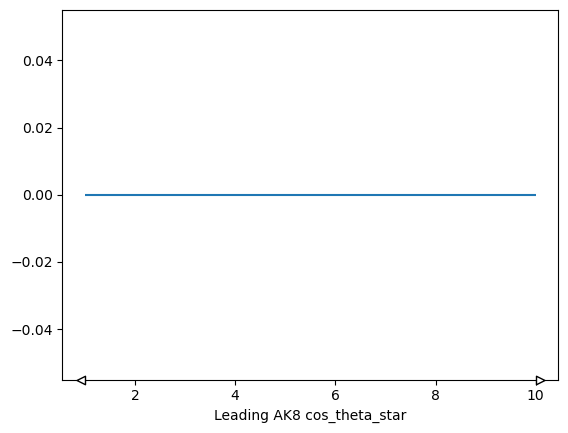

In [40]:
leading_cos_theta_star_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="Dataset", categories=[], growth=True),
                            hist.axis.Regular(name='leading_AK8_cos_theta_star', label='Leading AK8 cos_theta_star', bins=80, start=1, stop=10))
leading_cos_theta_star_hist.fill(dataset=test_dataset, leading_AK8_cos_theta_star=costhetastar)
leading_cos_theta_star_hist.plot1d()

<class 'vector.backends.awkward.MomentumArray3D'>
<class 'vector.backends.awkward.MomentumArray3D'>
[{x: 0.456, y: -0.841, z: 0.29}, {x: ..., ...}, ..., {x: 0.447, y: 0.894, z: 0}]
[{x: -0.717, y: -0.582, z: 0.382}, {...}, ..., {x: 0.513, y: -0.806, z: 0.295}]
[0.273, 0.671, 0.439, 0.143, 0.544, ..., 0.0861, 0.716, -0.966, 0.313, -0.492]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8025fe74a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

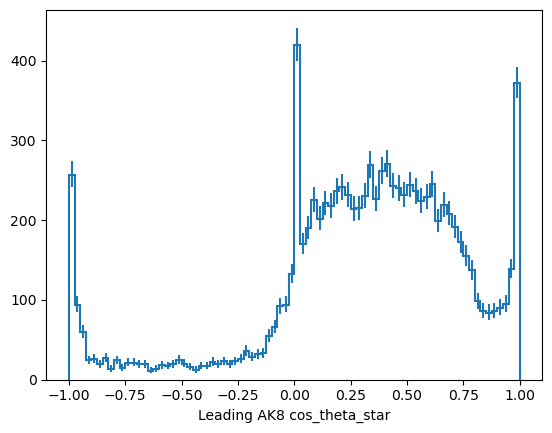

In [73]:
# print(fatjet_p4[:,0])
subjet_p4 = ak.zip({
    "pt": Wjets_candidates_subjets.pt,
    "eta": Wjets_candidates_subjets.eta,
    "phi": Wjets_candidates_subjets.phi,
    "mass": Wjets_candidates_subjets.mass,
}, with_name="Momentum4D")
# Step 2: Compute the boost to CM frame
#boost_vectors = subjet_p4[:,0].boostCM_of_p4(fatjet_p4[:,0])

# # Step 3: Apply the boost to each jet
# # This gives the FatJets *in the CM frame of the system*
# fj_boosted = fj_vectors.boost(boost_vectors)
# p_boson: Momentum4D vector of the vector boson candidate
# p_decay: Momentum4D vector of one of its decay products (e.g. the lepton or leading subjet)

# Step 1: Compute the CM frame boost of the boson
W_p4 = ak.sum(subjet_p4, axis=1)

# Step 3: Get boost vector — the **negative 3-momentum** of W divided by its energy
boost_vec = -W_p4.to_Vector3D() / W_p4.energy

# Step 4: Boost the subjets into the W rest frame
subjets_cm = subjet_p4.boost(boost_vec)


decay_product = subjets_cm[:, 0]  # pick leading subjet
W_direction = W_p4.to_Vector3D().unit()

decay_vec3 = decay_product.to_Vector3D()
decay_unit = decay_vec3.unit()   # property, no ()

print(type(decay_unit))
print(type(W_direction))
print(decay_unit)
print(W_direction)

cos_theta_star = decay_unit.dot(W_direction)  # this returns an awkward array of floats
#W_direction
print(cos_theta_star)#cos_theta_star = decay_product.to_Vector3D().unit() @ W_direction()  # cos(theta*)

leading_cos_theta_star_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="Dataset", categories=[], growth=True),
                            hist.axis.Regular(name='leading_AK8_cos_theta_star', label='Leading AK8 cos_theta_star', bins=80, start=-1, stop=1))
leading_cos_theta_star_hist.fill(dataset=test_dataset, leading_AK8_cos_theta_star=cos_theta_star)
leading_cos_theta_star_hist.plot1d()

ImportError: cannot import name 'CosTheta' from 'vector._compute' (/usr/local/lib/python3.12/site-packages/vector/_compute/__init__.py)

AssertionError: <ThreeVectorArray [[{rho: 349, phi: 1.65, ...}, ...], ...] type='10000 * va...'>

TypeError: <VectorArray3D [[{px: 21, py: -325, ...}, ...], ...] type='10000 * var * Ve...'> is not a 4D vector

AttributeError: 'MomentumNumpy4D' object has no attribute 'boostvec'

AttributeError: module 'awkward' has no attribute 'stack'

AttributeError: no field named 'boost'